## ${\color{hotpink} \text{Imports}}$

In [78]:
# for data manipulation
import glob
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder # needed for y values for knn to prevent ValueError when fitting

# for preprocessing of data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# all of the classifier methods from the labs (only required 3 of 5)
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import KFold
# from sklearn.naive_bayes import GaussianNB

# for finding the best hyperparameters
from sklearn.model_selection import GridSearchCV


# for evaluation of the models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## ${\color{hotpink} \text{Load the dataset into X}}$
${\color{lightgreen} \text{As the dataset is structured similar to the digits dataset from lab 5, the same method of preparing the data will be used}}$  
Referenced lab for data extraction  
https://github.com/Kevin-2002/Gesture_Based_UI_Development/blob/main/week5/digits.ipynb

In [79]:
# Get all of the filepaths into a list
# image_filepath = glob.glob('./fashion/*/*.png')

# portion of the data to use for training for less computational time
image_filepath = glob.glob('./fashion/bag/*.png')
image_filepath.extend(glob.glob('./fashion/coat/*.png'))

image_filepath.sort()

# Define batch size
batch_size = 1000  # Adjust based on your system's capacity

# Initialize empty array to store all images
total_images = len(image_filepath)
# Assuming all images are 28x28 based on your reshape operation
all_images = np.zeros((total_images, 28, 28), dtype=np.uint8)

# Process in batches
for i in range(0, total_images, batch_size):
    end_idx = min(i + batch_size, total_images)
    batch_filepaths = image_filepath[i:end_idx]

    # Load this batch
    batch_images = []
    for img_path in batch_filepaths:
        with Image.open(img_path) as img:
            # Convert to numpy array immediately and close file
            batch_images.append(np.array(img))

    # Store in the main array
    all_images[i:end_idx] = np.array(batch_images)

    # Force cleanup
    batch_images = None

# Reshape to your desired dimensions
X = all_images.reshape(total_images, 28*28)


## ${\color{hotpink} \text{Get the y values for each X}}$
${\color{lightgreen} \text{Which is the folder/label it is under.}}$

In [80]:
# . is at split index 0, fashion is at 1 and the category is at 2
y = np.array([image.split("/")[2] for image in image_filepath])
y

array(['bag', 'bag', 'bag', ..., 'coat', 'coat', 'coat'], dtype='<U4')

## ${\color{hotpink} \text{Preprocess the data}}$
>${\color{lightgreen} \text{Usually preprocessing images includes grayscaling and}}$  
>${\color{lightgreen} \text{resizing images to prepare data.}}$  
>${\color{lightgreen} \text{Those steps were already completed in the initial DataSet.}}$  

${\color{lightgreen} \text{Some models require normalization, also known as data scaling. SVM is an example.}}$  

In [81]:
# normalize the data
# according to the documentation 255 is the max value for the pixel (white), so we just divide by 255
# https://pillow.readthedocs.io/en/stable/reference/Image.html  
X = np.divide(X, 255)

# X[1]

# encode string labels to avoid the ValueError
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## ${\color{hotpink} \text{Split data into train and test sets}}$
${\color{lightgreen} \text{No need to split another time for validation, as Cross-Validation method will be used instead.}}$  

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=401808)#G00 401808

## ${\color{hotpink} \text{Find optimal HyperParamaters, via GridSearchCV}}$
${\color{lightgreen} \text{The reason the search grid is so little is because of expensive runtime costs}}$  

------

## ${\color{hotpink} \text{KNN Gridsearch}}$

In [83]:
# K-NearestClassifier paramaters search
# find the best amount of neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7], # number of neighbors
}

In [84]:
knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, param_grid_knn)

In [85]:
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7]})

In [86]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


------

## ${\color{hotpink} \text{RandomForest Gridsearch}}$

In [87]:
# Support Vector Machine paramaters search
# compare 2 at a time because 30 minutes elapsed without output meaning the 
# computational cost of running all 5 types is too much
param_grid_RandomForestClassifier = {
    'n_estimators': [50, 100], # Number of trees in the forest
    'max_depth': [10, 20, 30], # Maximum depth of the tree
}

In [88]:
RandomForestClassifier_model = RandomForestClassifier(random_state=401808)
RandomForestClassifier_grid = GridSearchCV(RandomForestClassifier_model, param_grid_RandomForestClassifier)

In [89]:
RandomForestClassifier_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=401808),
             param_grid={'max_depth': [10, 20, 30], 'n_estimators': [50, 100]})

In [90]:
print(RandomForestClassifier_grid.best_params_)

{'max_depth': 30, 'n_estimators': 50}


------

## ${\color{hotpink} \text{Logistic regression Gridsearch}}$

In [91]:
# Logistic Regression paramaters search
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
param_grid_logistic = {
    'C': [0.1, 1, 10], # Inverse of regularization strength
    'solver': ['saga', 'liblinear'], # Algorithm to use in the optimization problem
}

In [92]:
logistic_model = LogisticRegression(random_state=401808, max_iter=10000)
logistic_model_grid = GridSearchCV(logistic_model, param_grid_logistic)

In [93]:
logistic_model_grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=401808),
             param_grid={'C': [0.1, 1, 10], 'solver': ['saga', 'liblinear']})

In [94]:
print(logistic_model_grid.best_params_)

{'C': 0.1, 'solver': 'saga'}


------

## ${\color{hotpink} \text{Output from each GridSearchCV cell (as an image)}}$  

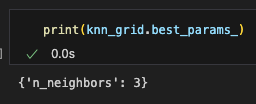

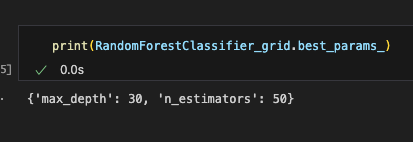

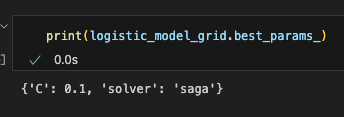

------

## ${\color{hotpink} \text{Build models with the best hyper-parameters}}$
${\color{lightgreen} \text{Note the output run from the gridsearch code above}}$  

In [95]:
# instantiate the classifiers
knn_model = KNeighborsClassifier(n_neighbors=3)
RandomForestClassifier_model = RandomForestClassifier(max_depth=30, n_estimators=50, random_state=401808)
logistic_model = LogisticRegression(C=0.1, solver='saga', max_iter=10000, random_state=401808)

In [96]:
knn_model = knn_model.fit(X_train, y_train)

In [97]:
rfc_model = RandomForestClassifier_model.fit(X_train, y_train)

In [98]:
logistic_model = logistic_model.fit(X_train, y_train)

## ${\color{hotpink} \text{Score each model and compare it with the cross validation}}$

In [99]:
print(knn_model.score(X_train, y_train))
print(cross_val_score(knn_model, X_train, y_train, cv=5))

print("final knn model score: ", knn_model.score(X_test, y_test))

0.9930357142857142
[0.98883929 0.98392857 0.98883929 0.98794643 0.98794643]
final knn model score:  0.9892857142857143


In [100]:
print(rfc_model.score(X_train, y_train))
print(cross_val_score(rfc_model, X_train, y_train, cv=5))

print("final rfc model score: ", rfc_model.score(X_test, y_test))

1.0
[0.99330357 0.98794643 0.99375    0.9875     0.990625  ]
final rfc model score:  0.9914285714285714


In [101]:
print(logistic_model.score(X_train, y_train))
print(cross_val_score(logistic_model, X_train, y_train, cv=5))

print("final logistic model score: ", logistic_model.score(X_test, y_test))

0.9910714285714286
[0.98616071 0.98660714 0.99017857 0.98482143 0.98794643]
final logistic model score:  0.9910714285714286


## ${\color{hotpink} \text{Data Visualisation}}$

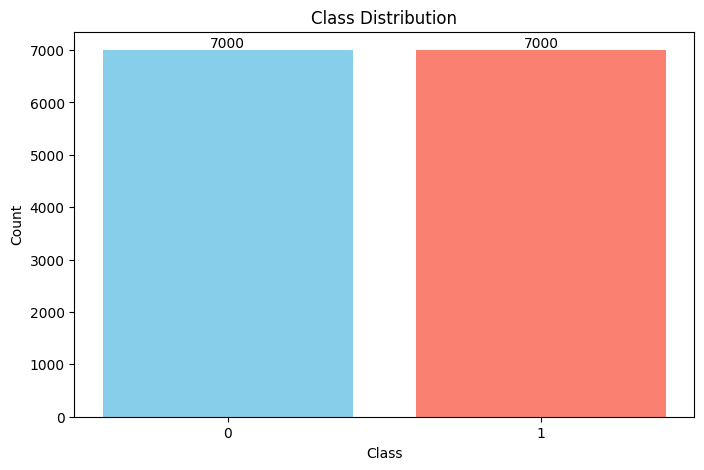

In [102]:
# Visualize class distribution
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique, counts, color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique)
for i, count in enumerate(counts):
    plt.text(unique[i], count + 50, str(count), ha='center')
plt.show()

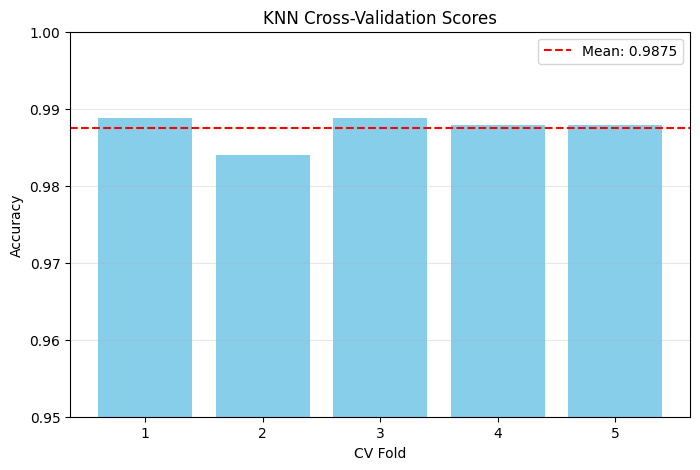

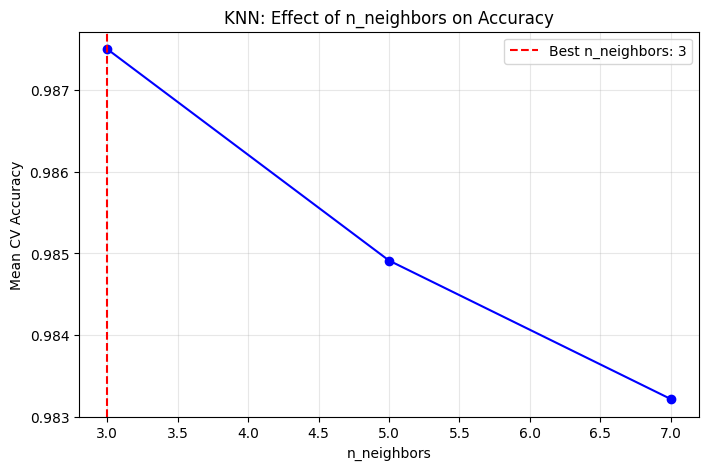

In [ ]:
# Plot cross-validation scores
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.title('KNN Cross-Validation Scores')
plt.xlabel('CV Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.ylim(0.95, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visualize KNN hyperparameter tuning results
param_values = [p['n_neighbors'] for p in knn_grid.cv_results_['params']]
mean_scores = knn_grid.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.plot(param_values, mean_scores, 'o-', color='blue')
plt.axvline(x=knn_grid.best_params_['n_neighbors'], color='red', linestyle='--', 
           label=f"Best n_neighbors: {knn_grid.best_params_['n_neighbors']}")
plt.title('KNN: Effect of n_neighbors on Accuracy')
plt.xlabel('n_neighbors')
plt.ylabel('Mean CV Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

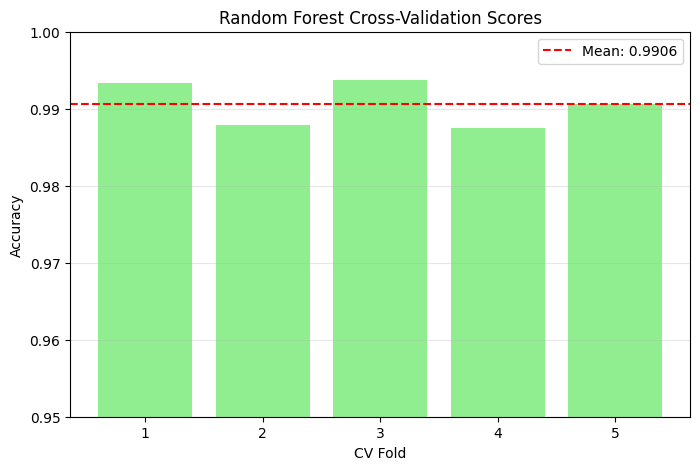

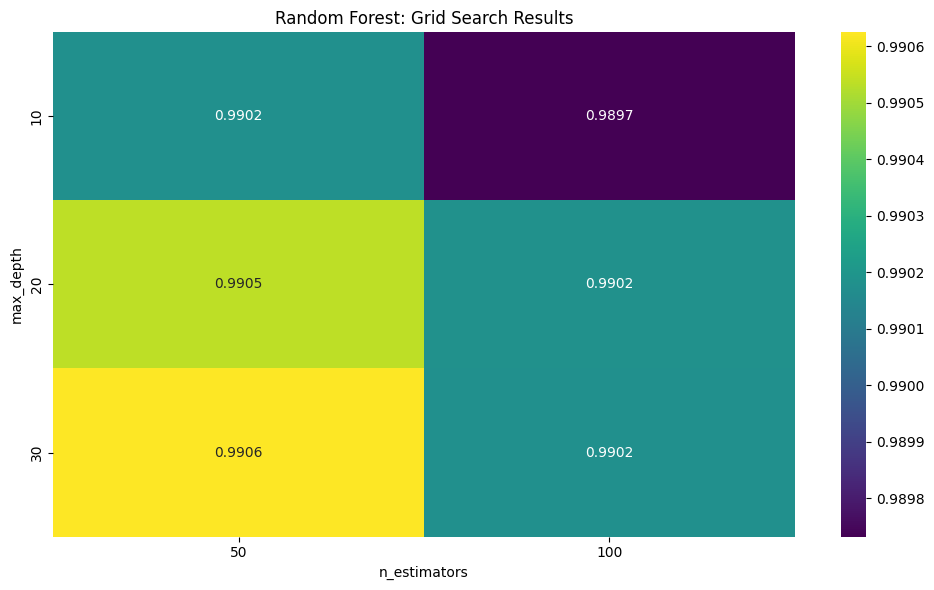

In [ ]:
# Plot cross-validation scores
cv_scores = cross_val_score(RandomForestClassifier_model, X_train, y_train, cv=5)
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='lightgreen')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.title('Random Forest Cross-Validation Scores')
plt.xlabel('CV Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.ylim(0.95, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Create a heatmap of RandomForest hyperparameter tuning results
max_depth_values = sorted(set([p['max_depth'] for p in RandomForestClassifier_grid.cv_results_['params']]))
n_estimators_values = sorted(set([p['n_estimators'] for p in RandomForestClassifier_grid.cv_results_['params']]))

# Reshape the scores for the heatmap
scores = np.zeros((len(max_depth_values), len(n_estimators_values)))
for i, md in enumerate(max_depth_values):
    for j, ne in enumerate(n_estimators_values):
        for k, params in enumerate(RandomForestClassifier_grid.cv_results_['params']):
            if params['max_depth'] == md and params['n_estimators'] == ne:
                scores[i, j] = RandomForestClassifier_grid.cv_results_['mean_test_score'][k]

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt='.4f', cmap='viridis', 
            xticklabels=n_estimators_values, yticklabels=max_depth_values)
plt.title('Random Forest: Grid Search Results')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.tight_layout()
plt.show()

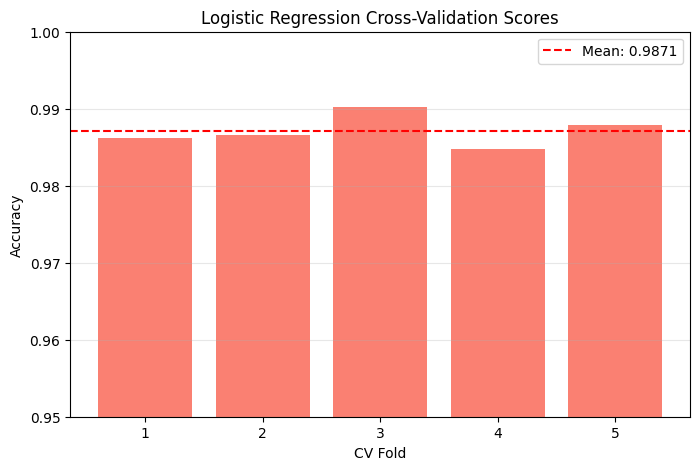

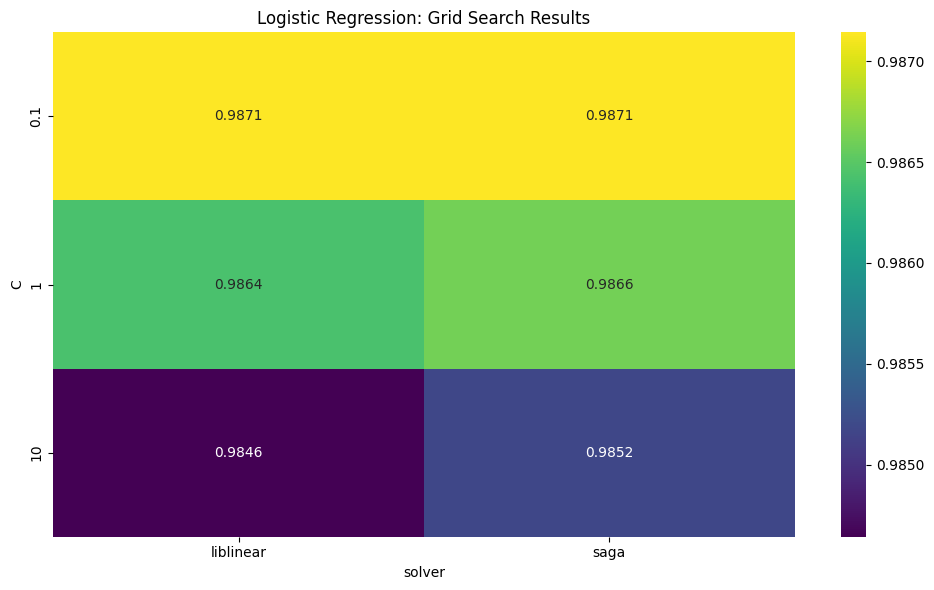

In [105]:
# Add after Logistic Regression cross-validation results
# Plot cross-validation scores
cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='salmon')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.title('Logistic Regression Cross-Validation Scores')
plt.xlabel('CV Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.ylim(0.95, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Create a heatmap of Logistic Regression hyperparameter tuning results
C_values = sorted(set([p['C'] for p in logistic_model_grid.cv_results_['params']]))
solver_values = sorted(set([p['solver'] for p in logistic_model_grid.cv_results_['params']]))

# Reshape the scores for the heatmap
scores = np.zeros((len(C_values), len(solver_values)))
for i, c in enumerate(C_values):
    for j, s in enumerate(solver_values):
        for k, params in enumerate(logistic_model_grid.cv_results_['params']):
            if params['C'] == c and params['solver'] == s:
                scores[i, j] = logistic_model_grid.cv_results_['mean_test_score'][k]

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt='.4f', cmap='viridis', 
            xticklabels=solver_values, yticklabels=C_values)
plt.title('Logistic Regression: Grid Search Results')
plt.xlabel('solver')
plt.ylabel('C')
plt.tight_layout()
plt.show()